<a href="https://colab.research.google.com/github/chidinma-godwin/course-recommendation-nlp/blob/main/course_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 55.7 MB/s eta 0:00:00


In [4]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Suppress the TqdmExperimentalWarning
from tqdm import TqdmExperimentalWarning
import warnings
warnings.filterwarnings('ignore', category=TqdmExperimentalWarning)

In [36]:
import re
import string
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import spacy

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Input, Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.models import Model

from sentence_transformers import SentenceTransformer

## Data Exploration

In [9]:
base_dir = "/content/drive/MyDrive/project"

df = pd.read_csv(f"{base_dir}/courseslist.csv")
df.head()

additional_course_detail  course_avg_rating  \
0  Welcome to the world of programming! Learn the...            4.84906   
1  ,This course bridges the gap between introduct...            3.66667   
2  This course takes Java beginners to the next l...            4.45000   
3  This Specialization builds on the success of t...            4.88462   
4  This course will introduce the core data struc...            4.89328   

   course_certificate      course_institution  course_is_classroom  \
0                True                     NaN                False   
1                True      Harvard University                False   
2                True   University of Alberta                False   
3                True  University of Michigan                False   
4                True  University of Michigan                False   

   course_is_university  course_level  \
0                 False      beginner   
1                  True  intermediate   
2                  True  intermediate   
3                  True      beginner   
4                  True      beginner   

                                         course_link  \
0  https://www.classcentral.com/course/intro-to-p...   
1  https://www.classcentral.com/course/python-har...   
2  https://www.classcentral.com/course/object-ori...   
3  https://www.classcentral.com/course/python-186...   
4  https://www.classcentral.com/course/python-dat...   

                   course_name  course_num_rating course_provider  \
0  Introduction to Programming                 53         Udacity   
1    Using Python for Research                 12             edX   
2       Object-Oriented Design                 40        Coursera   
3         Python for Everybody                416        Coursera   
4       Python Data Structures              16426        Coursera   

  course_subject      course_type  \
0    Programming  microcredential   
1    Programming           course   
2    Programming           course   
3         Python  microcredential   
4         Python           course   

                                         description          duration  \
0  Master coding basics with this 17-week Udacity...  4 months 3 weeks   
1  Master coding basics with this 17-week Udacity...  4 months 3 weeks   
2  Master coding basics with this 17-week Udacity...  4 months 3 weeks   
3  Master coding basics with this 17-week Udacity...  4 months 3 weeks   
4  Master coding basics with this 17-week Udacity...  4 months 3 weeks   

   is_all_time_best      pricing start_date  \
0             False  Paid Course  On-Demand   
1             False  Paid Course  On-Demand   
2             False  Paid Course  On-Demand   
3             False  Paid Course  On-Demand   
4             False  Paid Course  On-Demand   

                                             teacher  
0  Karl Krueger, Kelly Howard, Julia Van Cleve, J...  
1                              Jukka-Pekka JP Onnela  
2                                         Kenny Wong  
3                          Charles Russell Severance  
4                                  Charles Severance

In [11]:
df.duplicated().sum()

0

In [10]:
df = df.replace(np.nan, None)
df.isna().sum()

additional_course_detail        0
course_avg_rating               0
course_certificate              0
course_institution          20813
course_is_classroom             0
course_is_university            0
course_level                16715
course_link                     0
course_name                     0
course_num_rating               0
course_provider                 0
course_subject                  0
course_type                     0
description                     0
duration                       65
is_all_time_best                0
pricing                         0
start_date                      0
teacher                     10840
dtype: int64

In [ ]:
df['course_subject'].value_counts().reset_index().set_index('course_subject')

count
course_subject                    
Python                        1332
Microsoft Azure               1198
Google Cloud Platform (GCP)   1111
Uncategorized                 1008
Javascript                     812
...                            ...
Culture                          1
IT Compliance                    1
LDAP                             1
ASP.NET Core Blazor              1
Content Marketing                1

[937 rows x 1 columns]

In [ ]:
df['course_level'].value_counts(dropna=False).reset_index().set_index('course_level')

count
course_level       
None          16715
beginner      11844
intermediate   5625
advanced        979

In [ ]:
df['pricing'].value_counts().reset_index()

pricing  count
0           Free Online Course  11498
1         Free Trial Available   9615
2                  Paid Course   9502
3   Free Online Course (Audit)   2987
4              Conference Talk    747
5             Free Certificate    525
6                       $14.00     28
7                    $7,500.00     15
8                      $297.00     15
9                       $34.00     15
10                      $79.00     15
11                     $574.00     15
12                     $268.00     15
13                     $518.00     15
14                   $1,196.00     15
15                     $398.00     14
16                     $298.00     14
17                     $499.00     14
18                $50.00/month     14
19                     $876.00     14
20                     $196.00     13
21                     $670.00     13
22                     $567.00     13
23                     $747.00     11
24                   $1,245.00     11
25                     $597.00     10

In [ ]:
df['course_is_university'].value_counts().reset_index().set_index('course_is_university')

count
course_is_university       
False                 32392
True                   2771

In [ ]:
df['course_provider'].value_counts().reset_index().set_index('course_provider')

count
course_provider                      
YouTube                          8452
Udemy                            8248
Pluralsight                      4389
Coursera                         3711
LinkedIn Learning                3620
...                               ...
Marginal Revolution University      1
OpenLearning                        1
Stepik                              1
Semrush Academy                     1
Craftsy                             1

[75 rows x 1 columns]

In [ ]:
df[df['course_subject'] == 'Uncategorized'].head()

additional_course_detail  course_avg_rating  \
478  Introduction,Project Overview,Case Scenario,Al...                0.0   
479  Introduction,Linear approach,landscape changes...                0.0   
480  Introduction,Our Story Begins,The History of t...                0.0   
497  Stanford Seminar: PyWren - Pushing Microservic...                0.0   
498  Stanford Seminar: Data For The People, Andreas...                0.0   

     course_certificate   course_institution  course_is_classroom  \
478               False  Stanford University                 True   
479               False  Stanford University                 True   
480               False  Stanford University                 True   
497               False  Stanford University                 True   
498               False  Stanford University                 True   

     course_is_university course_level  \
478                  True         None   
479                  True         None   
480                  True         None   
497                  True         None   
498                  True         None   

                                           course_link  \
478  https://www.classcentral.com/classroom/youtube...   
479  https://www.classcentral.com/classroom/youtube...   
480  https://www.classcentral.com/classroom/youtube...   
497  https://www.classcentral.com/classroom/youtube...   
498  https://www.classcentral.com/classroom/youtube...   

                                           course_name  course_num_rating  \
478  Picking on the Same Person - Does Algorithmic ...                  0   
479  AI, Archaeology, and Archives - How Data Scien...                  0   
480  Voices in the Code - A Story About People, The...                  0   
497  Stanford Seminar - PyWren - Pushing Microservi...                  0   
498  Data for the People - Andreas Weigend of Socia...                  0   

    course_provider course_subject course_type  \
478         YouTube  Uncategorized      course   
479         YouTube  Uncategorized      course   
480         YouTube  Uncategorized      course   
497         YouTube  Uncategorized      course   
498         YouTube  Uncategorized      course   

                                           description    duration  \
478  Stanford University offers a brief seminar exp...  35 minutes   
479  Stanford University offers a brief seminar exp...  35 minutes   
480  Stanford University offers a brief seminar exp...  35 minutes   
497  Stanford University offers a brief seminar on ...  45 minutes   
498  Stanford University offers a brief seminar on ...  45 minutes   

     is_all_time_best             pricing start_date teacher  
478             False  Free Online Course  On-Demand    None  
479             False  Free Online Course  On-Demand    None  
480             False  Free Online Course  On-Demand    None  
497             False  Free Online Course  On-Demand    None  
498             False  Free Online Course  On-Demand    None

## Data Preprocessing

In [ ]:
# Function to create a meaningful combined course details
def create_combined_details(row):
    teacher_and_duration = ""
    if row['teacher'] and row['duration']:
        teacher_and_duration = f"The course was taught by {row['teacher']} and has a duration of {row['duration']}"
    elif row['teacher']:
        teacher_and_duration = f"The course was taught by {row['teacher']}"
    elif row['duration']:
        teacher_and_duration = f"The course has a duration of {row['duration']}"

    certificate = " You can get a certificate after completing this course" if row['course_certificate'] else ""

    course_institution = f" by {row['course_institution']}" if row['course_institution'] else ""

    course_level = f" and is classified as {row['course_level']} level" if row['course_level'] else ""

    combined_details = (
        f"""{row['course_name']}: This {re.sub(r' Course', '', row['pricing'])} course was rated by \
{row['course_num_rating']} people with an average rating of {round(row['course_avg_rating'], 1)}. {teacher_and_duration}. \
This {row['course_subject']} course is offered on {row['course_provider']}{course_institution}{course_level}.{certificate}. {row['additional_course_detail']}. {row['description']}"""
    )
    return combined_details

In [ ]:
# Apply the function to each row to create the combined text
df["combined_details"] = df.apply(create_combined_details, axis=1)
df["combined_details"][0]

'Introduction to Programming: This Paid course was rated by 53 people with an average rating of 4.8. The course was taught by Karl Krueger, Kelly Howard, Julia Van Cleve, James Parkes, Richard Kalehoff, Greg C., Yodit F., Matthew R., John M., Vincenzo A. and James L. and has a duration of 4 months 3 weeks. This Programming course is offered on Udacity and is classified as beginner level. You can get a certificate after completing this course. Welcome to the world of programming! Learn the skills that all programmers use, whether they build apps, web pages, or analyze data.,,. Master coding basics with this 17-week Udacity course. Learn HTML, CSS, Python, and JavaScript, with no prior programming skills required. Ideal for beginners eyeing careers in tech.'

In [ ]:
print("Min: ", min(df["combined_details"].str.split().apply(len)))
print("Max: ", max(df["combined_details"].str.split().apply(len)))

Min:  50
Max:  5448


In [ ]:
# Download NLTK data
nltk.download('stopwords')

# Initialize stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
nlp = spacy.load('en_core_web_sm')

def preprocess_texts(texts):
    preprocessed_texts = []

    for text in texts:
        text = text.lower()
        text = re.sub(r'(?<=\d)[.](?=\d)', '√√√DOT√√√', text)  # Temporarily replace "." between numbers
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  # Remove all punctuations
        text = re.sub(r'√√√DOT√√√', '.', text)  # Restore the preserved "."
        preprocessed_texts.append(text)

    lemmatized_texts = []

    for doc in nlp.pipe(preprocessed_texts, n_process=4, disable=["parser", "ner", "textcat"]):
        words = [token.lemma_ for token in doc if token.text not in stop_words]
        lemmatized_texts.append(' '.join(words))

    return lemmatized_texts

df['preprocessed_details'] = preprocess_texts(df['combined_details'])
df['preprocessed_details'][0]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


'introduction program pay course rate 53 people average rating 4.8 course teach karl krueger kelly howard julia van cleve james parkes richard kalehoff greg c yodit f matthew r john vincenzo james l duration 4 month 3 week programming course offer udacity classify beginner level get certificate complete course welcome world programming learn skill programmer use whether build app web page analyze data master code basic 17week udacity course learn html css python javascript prior programming skill require ideal beginner eye career tech'

In [ ]:
print("Min: ", min(df["preprocessed_details"].str.split().apply(len)))
print("Max: ", max(df["preprocessed_details"].str.split().apply(len)))

Min:  30
Max:  2841


## Data Visualization

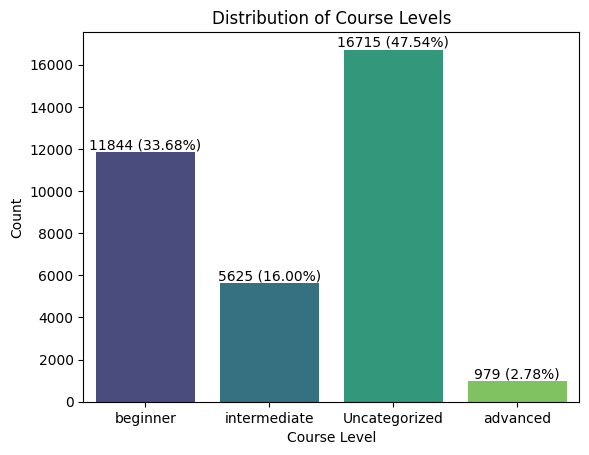

In [ ]:
filled_df = df['course_level'].fillna('Uncategorized', inplace=False)
ax = sns.countplot(x=filled_df, data=df, palette='viridis', hue=filled_df)
ax.set_title('Distribution of Course Levels')
ax.set_xlabel('Course Level')
ax.set_ylabel('Count')

# Add text on the bars
for rect in ax.patches:
    height = round(rect.get_height())
    percentage = (height / len(filled_df)) * 100
    ax.text(x=rect.get_x() + rect.get_width() / 2, y=height, s=f'{height} ({percentage:.2f}%)', ha='center', va='bottom')

plt.show()

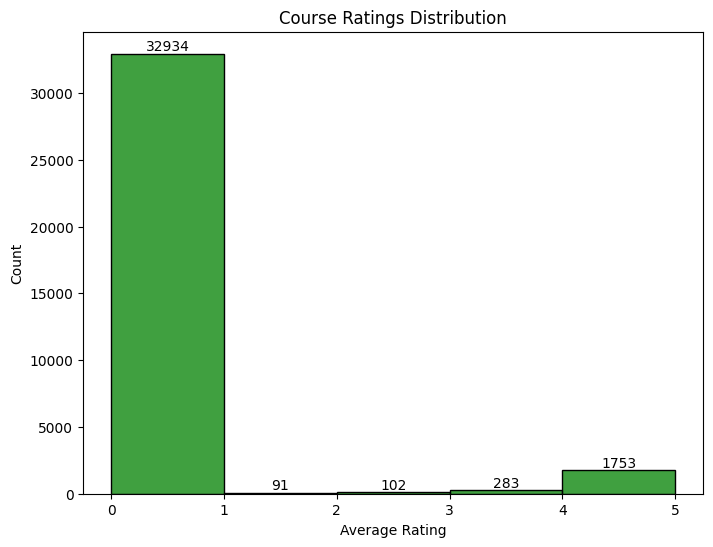

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(df['course_avg_rating'], bins=5, color='green', ax=ax)
ax.set_title('Course Ratings Distribution')
ax.set_xlabel('Average Rating')
ax.set_ylabel('Count')

# Add text on the bars
for rect in ax.patches:
    height = rect.get_height()
    ax.text(x=rect.get_x() + rect.get_width() / 2, y=height, s=height, ha='center', va='bottom')

plt.show()

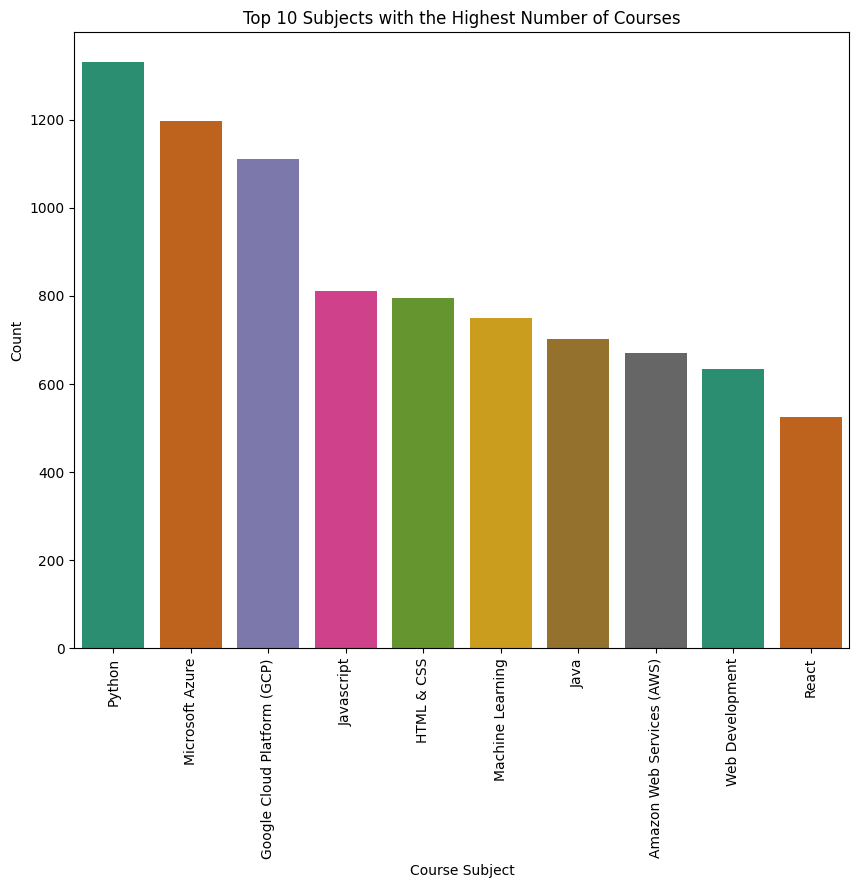

In [ ]:
top_subjects = df[df['course_subject'] != 'Uncategorized']['course_subject'].value_counts().reset_index()[:10]

fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(x='course_subject', y='count', data=top_subjects, palette='Dark2', hue='course_subject', ax=ax)
ax.set_title('Top 10 Subjects with the Highest Number of Courses')
ax.set_xlabel('Course Subject')
ax.set_ylabel('Count')

plt.xticks(rotation=90)
plt.show()

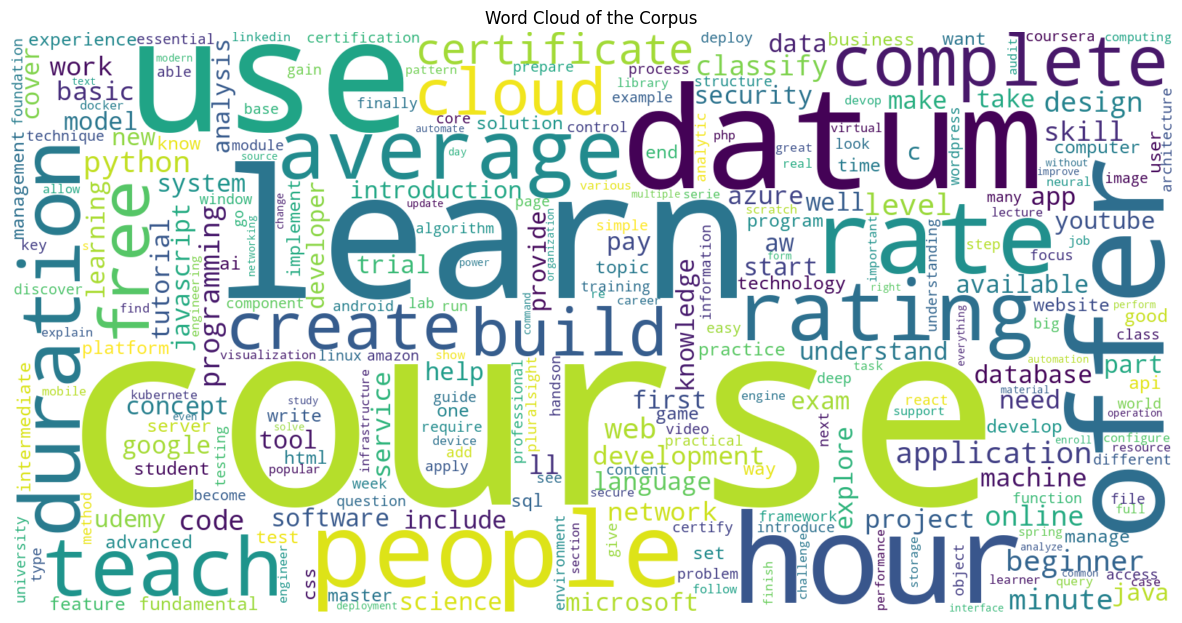

In [ ]:
wordcloud = WordCloud(width=1600, height=800, background_color='white', min_font_size=14,
                      collocations=False, max_words=500).generate(' '.join(df['preprocessed_details']))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of the Corpus')
plt.show()

## TF-IDF and Cosine Similarity

In [ ]:
def recommend_courses_cosine(user_query_embedding, course_embeddings, data, top_n=4):
    # Compute cosine similarity between user query and courses
    cosine_sim = cosine_similarity(user_query_embedding, course_embeddings).flatten()

    data['cosine_sim'] = cosine_sim
    # Get the top N similar courses
    top_indices = cosine_sim.argsort()[-top_n:][::-1]
    recommended_courses = data.iloc[top_indices]

    return recommended_courses

# Example user query
user_query = "I want advanced course on python covering OOP and data structures with an average rating above 4.0"
processed_user_query = preprocess_texts([user_query])[0]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
vectorizer = TfidfVectorizer()

# Vectorize the text data using TF-IDF
tfidf_matrix = vectorizer.fit_transform(df['preprocessed_details'])
user_tfidf = vectorizer.transform([processed_user_query])

# Get recommendations
cosine_recommendations = recommend_courses_cosine(user_tfidf, tfidf_matrix, df)
print("Cosine Similarity Recommendations:")
cosine_recommendations[['course_name', 'course_avg_rating', 'course_level', 'cosine_sim']]

Cosine Similarity Recommendations:


course_name  course_avg_rating  \
34964  Learn Kotlin Programming – Full Course for Beg...                0.0   
860    Python OOP : Four Pillars of OOP in Python 3 f...                0.0   
6556   Data Structures and OOP with C++ : CS104, CS10...                0.0   
2130   OOP in Python 3 for Machine Learning Beginners...                0.0   

      course_level  cosine_sim  
34964         None    0.492158  
860       beginner    0.477251  
6556      beginner    0.452569  
2130      beginner    0.452005

## Word2Vec and Cosine Similarity

In [ ]:
def get_average_word2vec(text, model):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

word2vec_model = Word2Vec(sentences=list(df["preprocessed_details"].str.split()), vector_size=300, window=5, min_count=1, workers=4)

course_embedding = df['preprocessed_details'].apply(lambda x: get_average_word2vec(x, word2vec_model))
user_query_embedding = get_average_word2vec(processed_user_query, word2vec_model)

cosine_recommendations = recommend_courses_cosine([user_query_embedding], course_embedding.tolist(), df)
print("Cosine Similarity Recommendations:")
cosine_recommendations[['course_name', 'course_avg_rating', 'course_level', 'cosine_sim']]

Cosine Similarity Recommendations:


course_name  course_avg_rating  \
25262                                Python for Students            0.00000   
4                                 Python Data Structures            4.89328   
1759   Learn NumPy Fundamentals (Python Library for D...            0.00000   
21476                                  Lets Learn Python            0.00000   

      course_level  cosine_sim  
25262         None    0.860800  
4         beginner    0.859832  
1759      beginner    0.855164  
21476     beginner    0.851917

In [ ]:
sims = word2vec_model.wv.most_similar('python', topn=10)  # get other similar words
for item in sims:
  print (item)

('panda', 0.6038721799850464)
('numpy', 0.564376175403595)
('rust', 0.5620310306549072)
('r', 0.5317306518554688)
('matplotlib', 0.5238746404647827)
('matlab', 0.5035416483879089)
('julia', 0.5000492930412292)
('seaborn', 0.4772483706474304)
('math', 0.4752694368362427)
('pandas', 0.45039811730384827)


## Doc2Vec and Cosine Similarity

In [ ]:
# Prepare data for Doc2Vec
documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(df['preprocessed_details'])]

# Train Doc2Vec model
doc2vec_model = Doc2Vec(documents, vector_size=200, window=5, min_count=1, workers=4, epochs=20)

# Sample user query
user_query_embedding = doc2vec_model.infer_vector(processed_user_query.split())

# Get course embeddings as a list of numpy arrays
course_embeddings = np.array(df['preprocessed_details'].apply(lambda x: doc2vec_model.infer_vector(x.split())).tolist())

# Recommend courses
recommended_courses = recommend_courses_cosine([user_query_embedding], course_embeddings, df)
print("Cosine Similarity Recommendations:")
recommended_courses[['course_name', 'course_avg_rating', 'course_level', 'cosine_sim']]

Cosine Similarity Recommendations:


course_name  course_avg_rating  \
4183                              Data Structures in C++                0.0   
23635                         Learning Java using JShell                0.0   
13937  Flutter 1.2 with Firebase&Stripe Build shop ap...                0.0   
11649            Algorithms and Data Structures - Part 2                0.0   

       course_level  cosine_sim  
4183   intermediate    0.514058  
23635      beginner    0.500613  
13937  intermediate    0.472535  
11649      beginner    0.449041

In [ ]:
sims = doc2vec_model.wv.most_similar('python', topn=10)  # get other similar words
for item in sims:
  print (item)

('panda', 0.5569027662277222)
('numpy', 0.4907836318016052)
('matplotlib', 0.483419269323349)
('r', 0.47346505522727966)
('java', 0.4723840355873108)
('programming', 0.45828351378440857)
('pandas', 0.4535349905490875)
('javascript', 0.4369319975376129)
('pythonpython', 0.43634602427482605)
('rust', 0.4355952739715576)


## Transformer and Cosine Similarity

In [ ]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

embedding = model.encode(df['preprocessed_details'].values)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
user_input_encoding = model.encode([processed_user_query])

# Get recommendations
cosine_recommendations = recommend_courses_cosine(user_input_encoding, embedding, df)
print("Cosine Similarity Recommendations:")
cosine_recommendations[['course_name', 'course_avg_rating', 'course_level', 'cosine_sim']]

Cosine Similarity Recommendations:


course_name  course_avg_rating  \
6556   Data Structures and OOP with C++ : CS104, CS10...                0.0   
12107  Python OOP - Object Oriented Programming for B...                0.0   
4183                              Data Structures in C++                0.0   
3987                    Data Analysis with Python Course                0.0   

       course_level  cosine_sim  
6556       beginner    0.651555  
12107      beginner    0.647894  
4183   intermediate    0.617137  
3987           None    0.616548

## Conversational Recommendation System

In [12]:
import random
import json
from sklearn.utils import shuffle
from datasets import load_dataset

# Load the CLINC150 dataset using Hugging Face
dataset = load_dataset('clinc_oos', 'plus')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [27]:
df_all = pd.concat([pd.DataFrame(dataset['train']), pd.DataFrame(dataset['validation']), pd.DataFrame(dataset['test'])])
df_selected = df_all[(df_all['intent']==42) | (df_all['intent']==82) | (df_all['intent']==114) | (df_all['intent']==124)]
oos_df = df_selected[df_selected['intent'] == 42].sample(n=300, random_state=42)
oos_df.loc[:, 'intent'] = 'oos'

df_selected = df_selected[df_selected['intent'] != 42]

df_selected.loc[df_selected['intent'] == 82, 'intent'] = 'greeting'
df_selected.loc[df_selected['intent'] == 114, 'intent'] = 'goodbye'
df_selected.loc[df_selected['intent'] == 124, 'intent'] = 'thank_you'

combined_df = pd.concat([df_selected, oos_df]).reset_index(drop=True)
combined_df['entities'] = [{} for _ in range(len(combined_df))]

combined_df

text     intent entities
0          you have been a big help, thank you so much  thank_you       {}
1                    i appreciate your help, thank you  thank_you       {}
2             i really appreciate your help, thank you  thank_you       {}
3                                   i am very grateful  thank_you       {}
4                          i appreciate the assistance  thank_you       {}
..                                                 ...        ...      ...
745     can you see the second right inside the fridge        oos       {}
746  make a list of all sites in the us where spiri...        oos       {}
747                                  is flu contagious        oos       {}
748                        is the brexit finalized yet        oos       {}
749       search my contacts for the auto repair place        oos       {}

[750 rows x 3 columns]

In [ ]:
# from transformers import PegasusTokenizer, PegasusForConditionalGeneration

# # Load pre-trained T5 model and tokenizer
# model_name = 'tuner007/pegasus_paraphrase'
# model = PegasusForConditionalGeneration.from_pretrained(model_name)
# tokenizer = PegasusTokenizer.from_pretrained(model_name)


# def paraphrase_intents(intents, max_length=60, num_beams=10):
#     paraphrased_intents = []
#     for intent in intents:
#         input_text = "paraphrase: " + intent
#         input_ids = tokenizer.encode(intent, return_tensors='pt', max_length=max_length, truncation=True)
#         paraphrased_ids = model.generate(input_ids, max_length=max_length, num_beams=num_beams, early_stopping=True)
#         paraphrased_text = tokenizer.decode(paraphrased_ids[0], skip_special_tokens=True)
#         paraphrased_intents.append(paraphrased_text)
#     return paraphrased_intents

In [14]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [28]:
# Define intents for different entities
recommend_intents = [
    {"sent": "Can you recommend some good courses on {}?", "slots": ["topic"]},
    {"sent": "I'm looking for a course on {}. Any suggestions?", "slots": ["topic"]},
    {"sent": "What are the best courses available for {}?", "slots": ["topic"]},
    {"sent": "Could you suggest a course related to {}?", "slots": ["topic"]},
    {"sent": "I need a course on {}. What do you recommend?", "slots": ["topic"]},
    {"sent": "Please recommend a course for {}.", "slots": ["topic"]},
    {"sent": "Any recommendations for {} courses?", "slots": ["topic"]},
    {"sent": "Suggest some top courses for {}.", "slots": ["topic"]},
    {"sent": "Which courses would you recommend for learning {}?", "slots": ["topic"]},
    {"sent": "Do you have any course suggestions for {}?", "slots": ["topic"]},
    {"sent": "Can you recommend an {} course on {}?", "slots": ["level", "topic"]},
    {"sent": "I'm looking for {} courses on {}. Any suggestions?", "slots": ["level", "topic"]},
    {"sent": "What {} {} courses can you recommend?", "slots": ["level", "topic"]},
    {"sent": "Could you recommend a {} {} course?", "slots": ["certified", "topic"]},
    {"sent": "Are there any {} courses rated by {} students that you can recommend?", "slots": ["topic", "num_rating"]},
    {"sent": "Please suggest some {} courses offered by {}.", "slots": ["topic", "provider"]},
    {"sent": "Can you recommend a {} level {} course with a duration of less than {}?", "slots": ["level", "topic", "duration"]},
    {"sent": "I'm looking for a {} course that provides {}.", "slots": ["topic", "certified"]},
    {"sent": "Which {} courses would you recommend for professionals?", "slots": ["topic", "level"]},
    {"sent": "Can you recommend some short courses on {}?", "slots": ["topic"]},
    {"sent": "Any online {} courses you can suggest?", "slots": ["topic"]},
    {"sent": "Suggest some {} courses with good reviews.", "slots": ["topic"]},
    {"sent": "I'm interested in {}. Any course recommendations?", "slots": ["topic"]},
    {"sent": "What are the best-rated {} courses?", "slots": ["topic"]},
    {"sent": "Can you recommend a {} course from a top university?", "slots": ["topic"]},
    {"sent": "Looking for a part-time {} course. Any suggestions?", "slots": ["topic"]},
    {"sent": "What are the top {} courses available online?", "slots": ["topic"]},
    {"sent": "Could you recommend a {} course that offers a {}?", "slots": ["topic", "certified"]},
    {"sent": "I'm looking for a comprehensive {} course. Any suggestions?", "slots": ["topic"]},
    {"sent": "Any specialized {} courses you can recommend?", "slots": ["topic"]},
    {"sent": "What are some good self-paced {} courses?", "slots": ["topic"]},
    {"sent": "I want to learn {} Python for data science", "slots": ["level", "topic"]},
    {"sent": "Can you recommend a {} course rated {}?", "slots": ["topic", "rating"]},
    {"sent": "Is there a {} course with a {} from {}?", "slots": ["topic", "certified", "institution"]},
    {"sent": "Can you recommend a course taught by {}?", "slots": ["teacher"]},
    {"sent": "What courses on {} does {} offer?", "slots": ["topic", "provider"]},
    {"sent": "Can you suggest a {} course available at {}?", "slots": ["topic", "institution"]},
    {"sent": "I want a {} course lasting {}. Any recommendations?", "slots": ["topic", "duration"]},
    {"sent": "Can you recommend a {} course costing {}?", "slots": ["topic", "pricing"]},
    {"sent": "I would like a {} level course on {} with a rating above {}", "slots": ["level", "topic", "rating"]},
    {"sent": "I would like to take an {} level course on {}.", "slots": ["level", "topic"]},
    {"sent": "I'm looking for a course on {}.", "slots": ["topic"]},
    {"sent": "I would like a {} course with a {} rating.", "slots": ["topic", "rating"]},
    {"sent": "Can you recommend a {} {} level {} course?", "slots": ["pricing", "level", "topic"]},
    {"sent": "I want a {} course that lasts {}", "slots": ["topic", "duration"]},
    {"sent": "I need a {} course with {} start date that gives {}.", "slots": ["topic", "start_date", "certified"]},
    {"sent": "Suggestions on {} {} course", "slots": ["level", "topic"]},
    {"sent": "What course covers {} and has a rating {}", "slots": ["topic", "rating"]},
    {"sent": "Which {} {} course can you recommend from a {}?", "slots": ["duration", "topic", "institution"]},
    {"sent": "Can you recommend {} courses on {}", "slots": ["duration", "topic"]},
    {"sent": "I would like a {} {} course with a rating {}", "slots": ["level", "topic", "rating"]},
    {"sent": "Does {} offer any course on {}", "slots": ["institution", "topic"]},
    {"sent": "Is there any {} course on {} offered on {}.", "slots": ["level", "topic", "provider"]},
    {"sent": "Are there any {} course that are rated by {} students with an average rating {}?", "slots": ["topic", "num_rating", "rating"]},
    {"sent": "I'm interested in a {} course", "slots": ["topic"]},
    {"sent": "What {} {} course can you recomment for a {} learner", "slots": ["duration", "topic", "level"]},
    {"sent": "What {} course with {} can you recommend for me", "slots": ["topic", "certified"]},
    {"sent": "Is there a {} course on {}", "slots": ["level", "topic"]},
    {"sent": "Can you suggest a course for {}?", "slots": ["topic"]},
    {"sent": "I'm interested in learning {}. What {} level course can you reommend", "slots": ["topic", "level"]},
]

details_intents = [
    {"sent": "Tell me more about the {} course.", "slots": ["course_name"]},
    {"sent": "I want details on the {} course.", "slots": ["course_name"]},
    {"sent": "Can you provide more information on the {} course?", "slots": ["course_name"]},
    {"sent": "Give me some details on the {} class.", "slots": ["course_name"]},
    {"sent": "I need to know more about the {} course.", "slots": ["course_name"]},
    {"sent": "What does the {} course cover?", "slots": ["course_name"]},
    {"sent": "Describe the {} course to me.", "slots": ["course_name"]},
    {"sent": "What's included in the {} course?", "slots": ["course_name"]},
    {"sent": "Could you explain the content of the {} course?", "slots": ["course_name"]},
    {"sent": "I'm interested in the {} course. Can you tell me more about it?", "slots": ["course_name"]},
    {"sent": "What is the level of the {} course?", "slots": ["course_name"]},
    {"sent": "Is the {} course {}?", "slots": ["course_name", "certified"]},
    {"sent": "How long is the {} course?", "slots": ["course_name"]},
    {"sent": "What rating does the {} course have?", "slots": ["course_name"]},
    {"sent": "Who is the provider of the {} course?", "slots": ["course_name"]},
    {"sent": "Can you give me details on the {} course?", "slots": ["course_name"]},
    {"sent": "Does the {} course offer a {}?", "slots": ["course_name", "certified"]},
    {"sent": "Is the {} course suitable for beginners?", "slots": ["course_name"]},
    {"sent": "What topics are covered in the {} course?", "slots": ["course_name"]},
    {"sent": "Who teaches the {} course?", "slots": ["course_name"]},
    {"sent": "Can you provide the syllabus for the {} course?", "slots": ["course_name"]},
    {"sent": "What are the prerequisites for the {} course?", "slots": ["course_name"]},
    {"sent": "Is the {} course self-paced?", "slots": ["course_name"]},
    {"sent": "Does the {} course have good reviews?", "slots": ["course_name"]},
    {"sent": "Is the {} course rated {}?", "slots": ["course_name", "rating"]},
    {"sent": "What is the difficulty level of the {} course?", "slots": ["course_name"]},
    {"sent": "Is there any {} upon completing the {} course?", "slots": ["certified", "course_name"]},
    {"sent": "Can you provide more info on the {} course provider?", "slots": ["course_name"]},
    {"sent": "Is the {} course self paced?", "slots": ["course_name"]},
    {"sent": "Is the {} course offered by {}?", "slots": ["course_name", "institution"]},
    {"sent": "Does the {} course start on {}?", "slots": ["course_name", "start_date"]},
    {"sent": "What is the price of the {} course?", "slots": ["course_name"]},
    {"sent": "How many ratings does the {} course have?", "slots": ["course_name"]},
    {"sent": "Is the {} course taught by {}?", "slots": ["course_name", "teacher"]},
    {"sent": "Which institution is offering the {} course?", "slots": ["course_name"]},
    {"sent": "Is the {} course {}", "slots": ["course_name", "pricing"]},
    {"sent": "Is there a {} for completing the {} course?", "slots": ["certified", "course_name"]},
    {"sent": "Which {} courses have the most ratings?", "slots": ["topic"]},
    {"sent": "I want to enroll in the {} course.", "slots": ["course_name"]},
    {"sent": "How can I sign up for the {} class?", "slots": ["course_name"]},
    {"sent": "I am interested in enrolling in the {} course.", "slots": ["course_name"]},
    {"sent": "What is the course link for the {} course?", "slots": ["course_name"]},
    {"sent": "I would like to register for the {} class.", "slots": ["course_name"]},
    {"sent": "What is the process to enroll in the {} course?", "slots": ["course_name"]},
    {"sent": "I'd like to sign up for the {} course.", "slots": ["course_name"]},
    {"sent": "I want to join the {} course.", "slots": ["course_name"]},
    {"sent": "How do I register for the {} course?", "slots": ["course_name"]},
    {"sent": "I need help enrolling in the {} course.", "slots": ["course_name"]},
    {"sent": "Can I enroll in the {} course now?", "slots": ["course_name"]},
    {"sent": "How can I join the {} course?", "slots": ["course_name"]},
    {"sent": "What steps do I need to take to enroll in the {} course?", "slots": ["course_name"]},
    {"sent": "Is enrollment open for the {} course?", "slots": ["course_name"]},
    {"sent": "I want to start the {} course. How can I enroll?", "slots": ["course_name"]},
    {"sent": "What are the enrollment dates for the {} course?", "slots": ["course_name"]},
    {"sent": "Where can I sign up for the {} course?", "slots": ["course_name"]},
    {"sent": "Is there an enrollment fee for the {} course?", "slots": ["course_name"]},
    {"sent": "What is the deadline to enroll in the {} course?", "slots": ["course_name"]},
    {"sent": "I need information on how to register for the {} course.", "slots": ["course_name"]},
    {"sent": "Is the {} course enrollment open?", "slots": ["course_name"]},
    {"sent": "Please provide the enrollment link for the {} course.", "slots": ["course_name"]}
]

topics = df['course_subject'].values

# Define entities for generation
entities = ["rating", "topic", "certified", "institution", "level", "link", "course_name",
    "num_rating", "provider", "duration", "pricing", "start_date", "teacher"]

# Define example values for each entity
entity_values = {
    "rating": ["high", "low", "4.5", "5.0", "greater than 4.0", "lesser than 3.8", "above 3.5"],
    "topic": df.loc[df["course_subject"] != "Uncategorized", "course_subject"].values,
    "certified": ["certificate", "certification"],
    "institution": [*df.loc[df['course_institution'].notna(), 'course_institution'].values, "top university"],
    "level": ["beginner", "intermediate", "advanced"],
    "link": df['course_link'].values,
    "course_name": df['course_name'].values,
    "num_rating": ["1000", "2000", "more than 1500", "less than 500"],
    "provider": df.loc[df['course_provider'].notna(), 'course_provider'].values,
    "duration": ["4 weeks", "6 months 3 weeks", "2 months", "more than 3 months", "less than 4 months", "self paced", "short"],
    "pricing": ["$50", "$100", "$200", "free"],
    "start_date": ["June 1", "July 15", "August 20", "flexible"],
    "teacher": ["John Doe", "Jane Smith", "Prof. Alan Turing"]
}

def generate_samples(intents):
    samples = []
    slots = []
    for _ in range(5):
        for intent_obj in intents:
            slots_obj = {s: random.choice(entity_values[s]) for s in intent_obj['slots']}
            samples.append(intent_obj["sent"].format(*slots_obj.values()))
            slots.append(slots_obj)

    return samples, slots


# Generate samples with entities
recommend_samples, recommend_slots_obj = generate_samples(recommend_intents)
details_samples, details_slots_obj = generate_samples(details_intents)

# Create a DataFrame for generated data
data = {
    'text': [sample for sample in recommend_samples + details_samples],
    'intent': ['recommend'] * len(recommend_samples) + ['details'] * len(details_samples),
    'entities': [entity for entity in recommend_slots_obj + details_slots_obj],
}

intent_df = pd.DataFrame(data)
all_intents_df = pd.concat([intent_df, combined_df]).reset_index(drop=True)

# Convert entity annotations to sequences of tags
def annotate_ner(text, entities):
    # words = text.split()
    words = nltk.word_tokenize(text)
    slots = ['O'] * len(words)

    for entity, value in entities.items():
        value_words = nltk.word_tokenize(value)
        for i, word in enumerate(words):
            if word in value_words:
                start_idx = words.index(value_words[0])
                slots[start_idx] = f'B-{entity}'
                for j in range(1, len(value_words)):
                    slots[start_idx + j] = f'I-{entity}'
    return slots

ner_tags = [annotate_ner(text, entities) for text, entities in zip(all_intents_df['text'], all_intents_df['entities'])]

all_intents_df['ner_tags'] = ner_tags

final_df = shuffle(all_intents_df, random_state=73).reset_index(drop=True)

final_df.head()

text     intent  \
0   search the web for monthly parking near my house        oos   
1             Can you suggest a course for Firebase?  recommend   
2  can you tell me until what time the stock mark...        oos   
3                              what channel is cw on        oos   
4  I am interested in enrolling in the Windows Se...    details   

                                            entities  \
0                                                 {}   
1                              {'topic': 'Firebase'}   
2                                                 {}   
3                                                 {}   
4  {'course_name': 'Windows Server with Powershel...   

                                            ner_tags  
0                        [O, O, O, O, O, O, O, O, O]  
1                     [O, O, O, O, O, O, B-topic, O]  
2               [O, O, O, O, O, O, O, O, O, O, O, O]  
3                                    [O, O, O, O, O]  
4  [O, O, O, O, O, O, O, B-course_name, I-course_...

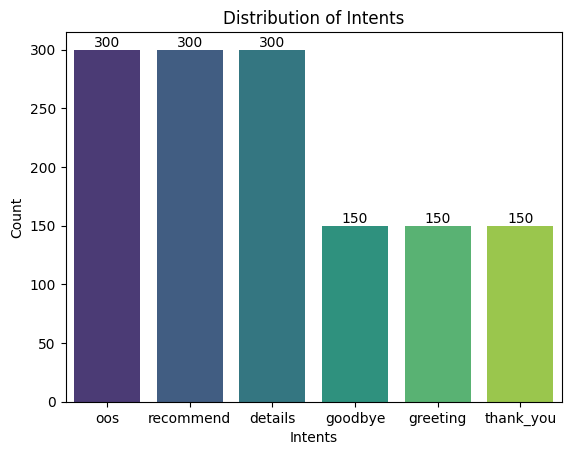

In [29]:
ax = sns.countplot(x='intent', data=final_df, palette='viridis', hue='intent')
ax.set_title('Distribution of Intents')
ax.set_xlabel('Intents')
ax.set_ylabel('Count')

# Add text on the bars
for rect in ax.patches:
    height = round(rect.get_height())
    ax.text(x=rect.get_x() + rect.get_width() / 2, y=height, s=height, ha='center', va='bottom')

plt.show()

In [220]:
embedding_dim = 50
lstm_units = 64

intent_label_encoder = LabelEncoder()
y_intent = intent_label_encoder.fit_transform(final_df['intent'])

all_slots = ["O", "B-rating", "I-rating", "B-topic", "I-topic", "B-certified", "I-certified", "B-institution", "I-institution", "B-level", "I-level" "B-link", "I-link", "B-course_name", "I-course_name",
    "B-num_rating", "I-num_rating", "B-provider", "I-provider", "B-duration", "I-duration", "B-pricing", "I-pricing", "B-start_date", "I-start_date", "B-teacher", "I-teacher"]
slot_label_encoder = LabelEncoder()
slot_label_encoder.fit(all_slots)

max_seq_length = len(all_slots)

# Text vectorization
vectorize_layer = TextVectorization(standardize='lower', output_sequence_length=max_seq_length)
vectorize_layer.adapt(final_df['text'].values)

# Convert sentences and labels to numpy arrays
X = vectorize_layer(final_df['text'].values).numpy()

vocab_size = len(vectorize_layer.get_vocabulary())

y_slots = [[slot_label_encoder.transform([tag])[0] for tag in tags] for tags in final_df['ner_tags']]
y_slots = tf.keras.preprocessing.sequence.pad_sequences(y_slots, maxlen=max_seq_length, padding='post', value=slot_label_encoder.transform(['O'])[0])

# Convert slot labels to one-hot encoding if necessary
y_slots = tf.keras.utils.to_categorical(y_slots, num_classes=len(all_slots))

# Convert intent labels to one-hot encoding if necessary
y_intent = tf.keras.utils.to_categorical(y_intent, num_classes=len(intent_label_encoder.classes_))

x_train, x_test, y_train_intent, y_test_intent, y_train_slots, y_test_slots = train_test_split(
    X, y_intent, y_slots, test_size=0.2, random_state=42)

In [221]:
input_text = Input(shape=(max_seq_length,), name='input_text')
embedding = Embedding(vocab_size, embedding_dim, input_length=max_seq_length, mask_zero=True)(input_text)

bi_lstm = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding)
dropout1 = Dropout(0.2)(bi_lstm)

lstm = LSTM(lstm_units, return_sequences=True)(dropout1)
dropout2 = Dropout(0.2)(lstm)

dense = Dense(64, activation='relu')(dropout2)

# Intent classification
intent_output = Dense(len(intent_label_encoder.classes_), activation='softmax', name='intent_output')(dense[:, -1, :])

# Slot filling
slot_output = TimeDistributed(Dense(len(all_slots), activation='softmax'), name='slot_output')(dense)

# Model compilation
model = Model(inputs=input_text, outputs=[intent_output, slot_output])
model.compile(optimizer='adam',
              loss={'intent_output': 'categorical_crossentropy', 'slot_output': 'categorical_crossentropy'},
              metrics={'intent_output': 'accuracy', 'slot_output': 'accuracy'})

# Model summary
model.summary()

Model: "model_53"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_text (InputLayer)     [(None, 26)]                 0         []                            
                                                                                                  
 embedding_58 (Embedding)    (None, 26, 50)               114400    ['input_text[0][0]']          
                                                                                                  
 bidirectional_66 (Bidirect  (None, 26, 128)              58880     ['embedding_58[0][0]']        
 ional)                                                                                           
                                                                                                  
 dropout_81 (Dropout)        (None, 26, 128)              0         ['bidirectional_66[0][0

In [222]:
history = model.fit(x_train, {'intent_output': y_train_intent, 'slot_output': y_train_slots}, validation_split=0.2, epochs=100, batch_size=16)

Epoch 1/100
54/54 [==============================] - 19s 140ms/step - loss: 3.6300 - intent_output_loss: 1.6137 - slot_output_loss: 2.0163 - intent_output_accuracy: 0.3171 - slot_output_accuracy: 0.7280 - val_loss: 2.3270 - val_intent_output_loss: 1.3054 - val_slot_output_loss: 1.0216 - val_intent_output_accuracy: 0.4306 - val_slot_output_accuracy: 0.7931
Epoch 2/100
54/54 [==============================] - 3s 50ms/step - loss: 2.0165 - intent_output_loss: 1.1426 - slot_output_loss: 0.8739 - intent_output_accuracy: 0.5417 - slot_output_accuracy: 0.7920 - val_loss: 1.8508 - val_intent_output_loss: 1.0516 - val_slot_output_loss: 0.7991 - val_intent_output_accuracy: 0.5648 - val_slot_output_accuracy: 0.7979
Epoch 3/100
54/54 [==============================] - 4s 81ms/step - loss: 1.5118 - intent_output_loss: 0.7948 - slot_output_loss: 0.7170 - intent_output_accuracy: 0.7199 - slot_output_accuracy: 0.8134 - val_loss: 1.4591 - val_intent_output_loss: 0.7611 - val_slot_output_loss: 0.6981 - 

In [223]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle('Learning curve for Slot Filling')

axes[0].set_title('Traing and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].plot(history.history['slot_output_loss'], label='train')
axes[0].plot(history.history['val_slot_output_loss'], label='val')
axes[0].legend()

axes[1].set_title('Traing and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].plot(history.history['slot_output_accuracy'], label='train')
axes[1].plot(history.history['val_slot_output_accuracy'], label='val')
axes[1].legend()

plt.show()

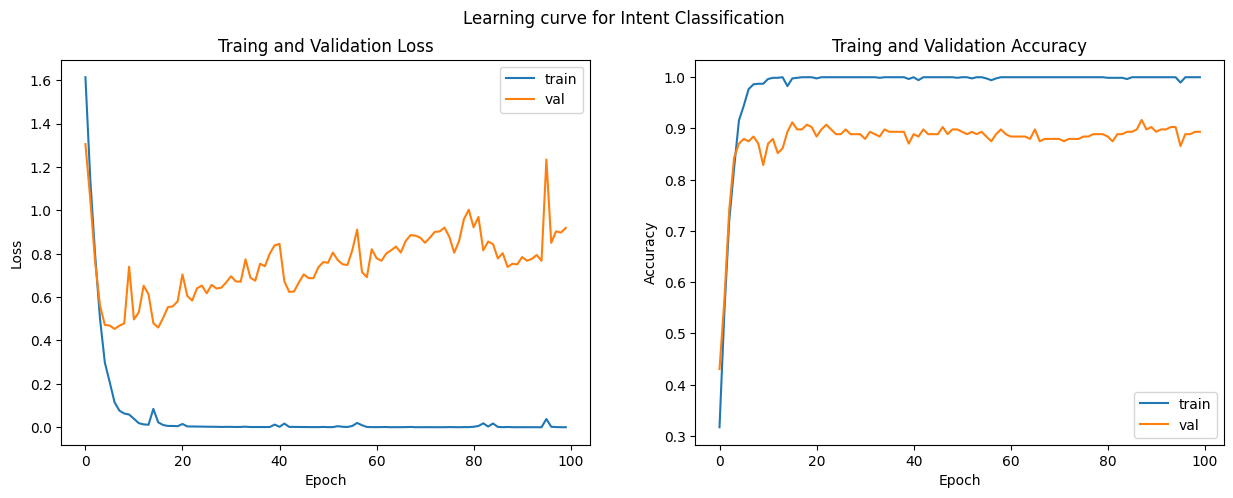

In [224]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle('Learning curve for Intent Classification')

axes[0].set_title('Traing and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].plot(history.history['intent_output_loss'], label='train')
axes[0].plot(history.history['val_intent_output_loss'], label='val')
axes[0].legend()

axes[1].set_title('Traing and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].plot(history.history['intent_output_accuracy'], label='train')
axes[1].plot(history.history['val_intent_output_accuracy'], label='val')
axes[1].legend()

plt.show()

In [225]:
model.evaluate(x_test, {'intent_output': y_test_intent, 'slot_output': y_test_slots}, batch_size=32)

9/9 [==============================] - 0s 32ms/step - loss: 1.3295 - intent_output_loss: 0.8326 - slot_output_loss: 0.4969 - intent_output_accuracy: 0.9037 - slot_output_accuracy: 0.9352


[1.3294610977172852,
 0.8325724005699158,
 0.49688878655433655,
 0.9037036895751953,
 0.9351687431335449]

In [252]:
def predict_intent_and_slots(sentence, label_encoder, slot_encoder):
    sentence_seq = vectorize_layer([sentence]).numpy()

    # Make predictions
    intent_pred, slot_pred = model.predict(sentence_seq)

    # Decode intent
    intent_idx = np.argmax(intent_pred, axis=1)
    intent_dict = {"intent": label_encoder.inverse_transform(intent_idx)[0]}

    # # Decode slot labels
    slot_idx = np.argmax(slot_pred[0], axis=1)
    slot_label = slot_encoder.inverse_transform(slot_idx)
    input_tokens = sentence.split()
    trimmed_slots = slot_label[:len(input_tokens)]
    indices = [i for i in range(len(trimmed_slots)) if trimmed_slots[i] != 'O']

    slots_dict = {}
    for i in indices:
        slot = trimmed_slots[i].split('-')[1]
        slots_dict[slot] = slots_dict[slot] + f" {sentence.split()[i]}" if slot in slots_dict else sentence.split()[i]

    return intent_dict, slots_dict

intent, slot = predict_intent_and_slots("I want advanced course on python covering OOP and data structures with an average rating above 4.0", intent_label_encoder, slot_label_encoder)

print(f"Intent: {intent}")
print(f"Slot: {slot}")

1/1 [==============================] - 0s 36ms/step
Intent: {'intent': 'recommend'}
Slot: {'level': 'advanced', 'topic': 'python covering OOP and data structures', 'rating': '4.0'}
